In [3]:
from scipy.io import loadmat
import numpy as np
import mne
import matplotlib.pyplot as plt

In [4]:
# 1. Load the .mat file
data = loadmat('sampleEEGdata.mat')
EEG = data['EEG']
eeg_data = EEG['data'][0, 0] #eeg_data.shape=(64, 640, 99), [channels:64, time points:640, trials:99]
times = EEG['times'][0, 0][0] #times.shape= (640,)
print('EEG.shape:', EEG.shape) #EEG.shape: (1, 1)
print('eeg_data.shape:', eeg_data.shape) #EEG.shape: (1, 1)
print('times.shape:', times.shape) #EEG.shape: (1, 1)
microvolt = "µV"
################################################################
# Read the file content
with open('eloc64C2.txt', 'r') as f:
    lines = f.readlines()
# Extract channel names, theta, and radius
channel_names = [line.split()[3].replace('.', '') for line in lines[0:]]  # Skip the header
theta = np.array([float(line.split()[1])-90 for line in lines[0:]]) * np.pi / 180.0  # Convert to radians
radius = np.array([float(line.split()[2]) for line in lines[0:]])
# Convert polar to Cartesian
x = radius * np.cos(theta)/5
y = -radius * np.sin(theta)/5
z = np.zeros_like(x)  # default z-coordinate for all channels
# Create a montage
ch_pos = dict(zip(channel_names, zip(x, y, z)))
montage = mne.channels.make_dig_montage(ch_pos, coord_frame='head')
info = mne.create_info(ch_names=channel_names, sfreq=256, ch_types='eeg')
# Apply the montage to the info
info.set_montage(montage)

EEG.shape: (1, 1)
eeg_data.shape: (64, 640, 99)
times.shape: (640,)


<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Af7, Af3, F1, F3, F5, F7, Ft7, Fc5, Fc3, Fc1, C1, C3, C5, ...
 chs: 64 EEG
 custom_ref_applied: False
 dig: 67 items (3 Cardinal, 64 EEG)
 highpass: 0.0 Hz
 lowpass: 128.0 Hz
 meas_date: unspecified
 nchan: 64
 projs: []
 sfreq: 256.0 Hz
>

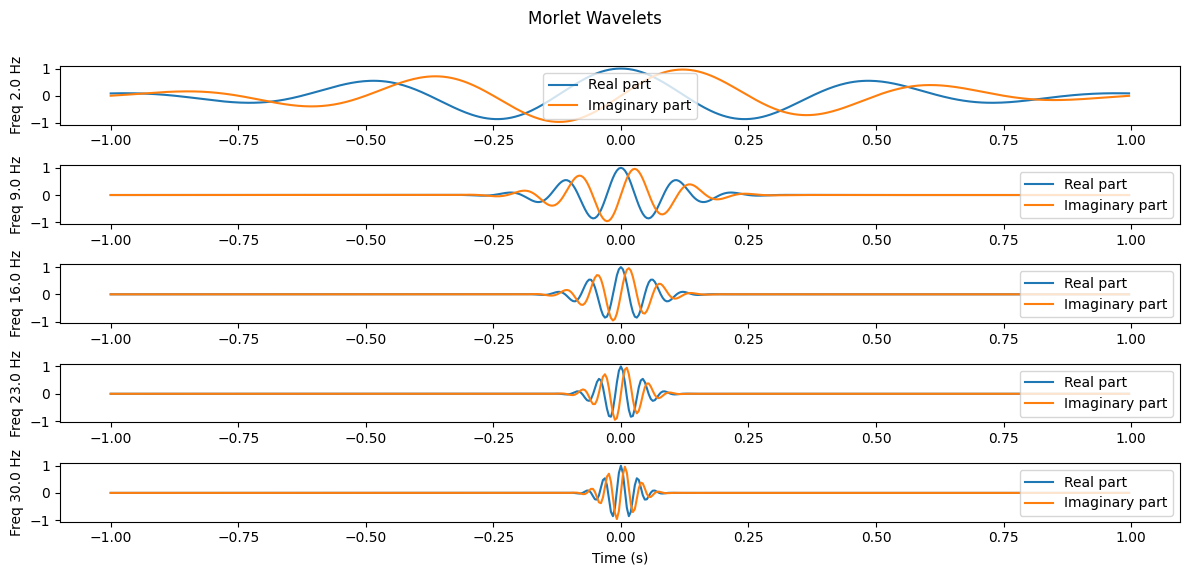

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def morlet_wavelet(frequency, num_cycles, sampling_rate, duration=2):
    t = np.linspace(-duration/2, duration/2, int(sampling_rate * duration), endpoint=False)
    sine_wave = np.exp(2j * np.pi * frequency * t)  # Complex sine wave
    amplitude_envelope = np.exp(-t**2 * (np.pi * frequency / num_cycles)**2)  # Gaussian envelope
    wavelet = sine_wave * amplitude_envelope
    return wavelet

def plot_wavelets(t, wavelets, frequencies, title="Morlet Wavelets"):
    plt.figure(figsize=(12, 6))
    for i, wavelet in enumerate(wavelets):
        plt.subplot(len(wavelets), 1, i + 1)
        plt.plot(t, wavelet.real, label=f"Real part")
        plt.plot(t, wavelet.imag, label=f"Imaginary part")
        plt.ylabel(f"Freq {frequencies[i]} Hz")
        plt.legend()
    plt.xlabel("Time (s)")
    plt.suptitle(title)
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.show()

# Parameters
frequencies = np.linspace(2, 30, 5)
num_cycles = 4
sampling_rate = 256

# Generate and plot the wavelets
wavelets = [morlet_wavelet(f, num_cycles, sampling_rate) for f in frequencies]
duration = 2  # default value
t = np.linspace(-duration/2, duration/2, int(sampling_rate * duration), endpoint=False)
plot_wavelets(t, wavelets, frequencies)




In [6]:
import pandas as pd
from scipy.io import loadmat
import numpy as np
import mne

# Load electrode locations
elec_df = pd.read_csv('eloc64C2.txt', sep='\t', header=None, names=['Index', 'Angle', 'Radius', 'Label'])
elec_df['X'] = elec_df['Radius'] * np.cos(np.radians(elec_df['Angle']))
elec_df['Y'] = -elec_df['Radius'] * np.sin(np.radians(elec_df['Angle']))

# Correcting the scales
elec_df['Angle'] = elec_df['Angle'] - 90
elec_df['X_scaled'] = elec_df['Radius'] * np.cos(np.radians(elec_df['Angle'])) / 5
elec_df['Y_scaled'] = -elec_df['Radius'] * np.sin(np.radians(elec_df['Angle'])) / 5

# Removing dots and converting labels to uppercase
elec_df['Label'] = elec_df['Label'].str.replace('.', '', regex=True).str.upper()

# Load EEG data (replace with the actual structure of your MAT file)
mat_data = loadmat('sampleEEGdata.mat')
eeg_data = mat_data['EEG'][0][0]['data']
chan_names = [str(chan[0]) for chan in mat_data['EEG'][0][0]['chanlocs'][0]['labels']]
sfreq = float(mat_data['EEG'][0][0]['srate'][0][0])
times = mat_data['EEG']['times'][0, 0][0]

# time Origin correction
offset = -times[0] / 1000 # in seconds
annotations = mne.Annotations(onset=[offset], duration=[0], description=['origin'])

# Selecting the first trial
eeg_data_first_trial = eeg_data[:, :, 0]

# Convert electrode locations from dataframe to DigMontage
chan_names = [name.upper() for name in chan_names]
montage = mne.channels.make_dig_montage(
    ch_pos=dict(zip(elec_df['Label'], zip(elec_df['X_scaled'], elec_df['Y_scaled'], [0]*len(elec_df)))),
    coord_frame='head')

# Create an MNE Info object
info = mne.create_info(ch_names=chan_names, sfreq=sfreq, ch_types='eeg')
raw = mne.io.RawArray(eeg_data_first_trial, info)

# Set montage and annotations
raw.set_montage(montage)
raw.set_annotations(annotations)


Creating RawArray with float64 data, n_channels=64, n_times=640
    Range : 0 ... 639 =      0.000 ...     2.496 secs
Ready.


<RawArray | 64 x 640 (2.5 s), ~410 kB, data loaded>

In [9]:
import mne
import numpy as np
from scipy.io import loadmat

# Extract the data for the first trial
eeg_data_first_trial = eeg_data[:, :, 0]

# The rest remains as previously outlined:

def morlet_wavelet(frequency, num_cycles, sampling_rate, duration=2):
    t = np.linspace(-duration/2, duration/2, int(sampling_rate * duration), endpoint=False)
    sine_wave = np.exp(2j * np.pi * frequency * t)  # Complex sine wave
    amplitude_envelope = np.exp(-t**2 * (np.pi * frequency / num_cycles)**2)  # Gaussian envelope
    wavelet = sine_wave * amplitude_envelope
    return wavelet

def convolve_with_wavelet(data, wavelet):
    n_signal = data.shape[1]
    n_wavelet = len(wavelet)
    n_convolution = n_signal + n_wavelet - 1

    data_fft = np.fft.fft(data, n_convolution, axis=1)
    wavelet_fft = np.fft.fft(wavelet, n_convolution)[np.newaxis, :]

    convolution_result_fft = data_fft * wavelet_fft
    convolution_result = np.fft.ifft(convolution_result_fft, axis=1)

    # Cut the data
    start = (n_wavelet - 1) // 2
    end = start + n_signal
    return convolution_result[:, start:end]

sampling_rate = 256
frequencies = np.linspace(2, 30, 5)
num_cycles = 4
convolved_data_list = []

for f in frequencies:
    wavelet = morlet_wavelet(f, num_cycles, sampling_rate)
    convolved_data = convolve_with_wavelet(eeg_data_first_trial, wavelet)
    convolved_data_list.append(convolved_data)


In [10]:
convolved_data_list

[array([[-241.35169122+233.80903807j, -253.949509  +221.33223172j,
         -266.39049911+208.18030175j, ..., -198.46647481-167.80362978j,
         -189.45344922-177.69560129j, -179.38508491-187.10147244j],
        [-275.20364055+141.03684103j, -284.00281821+127.2956192j ,
         -292.28469045+113.05258342j, ..., -166.78725039+105.33713537j,
         -170.83114457 +96.95857126j, -174.33323184 +88.44689183j],
        [-231.19312424 +40.49551551j, -234.60467781 +28.53615177j,
         -238.15514007 +16.33270292j, ..., -273.40747383-176.09177608j,
         -264.54090657-189.44047149j, -254.16213855-202.28319022j],
        ...,
        [-254.48899147 +55.93015595j, -259.69494263 +43.77201664j,
         -265.09102999 +31.25778694j, ...,  -90.57032735-315.90516429j,
          -76.52477933-320.35083181j,  -61.77311202-324.09912858j],
        [-274.22428348 -29.30814832j, -275.95491977 -42.70097637j,
         -277.7085868  -56.30486761j, ...,   76.87536456+225.99915512j,
           64.580836